# Classification of images of producs (Fruits and Vegetables)

Our original given dataset consisted of 3625 images split into three categories: Train, Test, Validation, and further into different types of produce.

Train sets usually consist of around 100 images per produce, test and validation of around 10. 

After performing exploratory analysis, comprising of examing data sizes, formats and color palletes/depths/counts, we started preprocessing.

The dataset had some same pictures in both test/validation and train data, which inflated accuracy, so those were removed from train data. Furthermore, to offset the removal of data we added some additional data of our own (both pictures taken by overselves, found from open sources and modifications of existing data as described later).

Our preprocessing consists of conversion to RGB, resizing the images to 150x150 px. We decided for a higher pixel count to maintain as much data as possible. However, it lowered performance of everything for obvious reasons.

To counter that, we used python pickle package to transform the data into byte stream for faster loading of data.

Between those two steps, we also randomly added pictures that were randomly augmented (flipped or rotated) to enhance our dataset.

Lastly we normalized the pixel values by dividing them by 255 (maximum value possible at the current point of preprocessing).

As for the models, our focus was on our custom CNN model, but we also implemented KNN, decision tree and random forest models.


In [9]:
!pip install colorthief

  Using cached colorthief-0.2.1-py2.py3-none-any.whl (6.1 kB)


Importing required packages.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import seaborn as sns
import numpy as np
import os  # Traversing file paths
import pickle  # Package for compressing image data in the form of the numpy array
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import pandas as pd

# 3 packages for exploratory analysis
from PIL import Image
from colorthief import ColorThief
from matplotlib.image import imread

# Packages for chosen models
from keras.preprocessing.image import ImageDataGenerator
from math import sqrt, inf
from random import random

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras import layers

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

Definition of constants and categorical dictionaries.

In [12]:
IMAGE_SIZE = 150
BATCH_SIZE = 128

categories = {"apple": 1, "banana": 2, "beetroot": 3,
              "bell pepper": 4, "cabbage": 5, "capsicum":6,
              "carrot": 7, "cauliflower": 8, "chilli pepper": 9,
              "corn": 10, "cucumber": 11, "eggplant": 12,
              "garlic": 13, "ginger": 14, "grapes": 15,
              "jalepeno": 16, "kiwi": 17, "lemon": 18,
              "lettuce": 19, "mango": 20, "onion": 21,
              "orange": 22, "paprika": 23, "pear": 24,
              "peas": 25, "pineapple": 26, "pomegranate": 27,
              "potato": 28, "raddish": 29, "soy beans": 30,
              "spinach": 31, "sweetcorn": 32, "sweetpotato": 33,
              "tomato": 34, "turnip": 35, "watermelon": 36}

for key, value in categories.items():
    categories[key] = value-1

rev_cat = {}
for veg, num in categories.items():
    rev_cat[num] = veg

Function for basic preprocessing. Resizing the images and saving tham in the compressed format with the pickle library. This was done locally in our systems. Data is uploaded in the compressed format already.

We have chosen the size of the images 150x150.

This function will not work in jupyter notebook as the raw images are not present due to their size.

After resizing every image we decided to rotate or flip images to introduce image augmentation. There is a chance that image won't be altered at all.

In [13]:
def rotate_or_flip(image):
    if random() < 0.5:
        f = random()
        if f <= 0.3:
            return np.rot90(image, 1)
        elif f <= 0.6:
            return np.rot90(image, 2)
        return np.rot90(image, 3)

    if random() < 0.5:
        return np.flipud(image)
    return np.fliplr(image)

    
def change_size_and_pickle(subfolder="train"):
    image_size = 150
    X = []
    y = []

    for root, directories, files in os.walk(PATH + "\\" + "dataset\\" + subfolder):
        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as image:
                path = "\\" + root.split("\\")[-1] + "_" + file.split(".")[0] + ".jpg"
                image = image.resize((image_size, image_size))
                image = np.array(image.convert('RGB'))

                if random() < 0.5:
                    new_image = rotate_or_flip(image)
                    X.append(new_image)
                    y.append(categories[root.split("\\")[-1]])
                    
                X.append(image)
                y.append(categories[root.split("\\")[-1]])
                
    y = np.array(y)
    X = np.array(X)

    X = X / 255.0
    X = X.reshape(-1, image_size, image_size, 3)

    with open('X_pickle_' + subfolder, 'wb') as pickle_out:
        pickle.dump(X, pickle_out)
    with open('y_pickle_' + subfolder, 'wb') as pickle_out:
        pickle.dump(y, pickle_out)

Function for loading the pickled data into the numpy arrays.

In [14]:
def get_data():
    X = pickle.load(open('/content/drive/MyDrive/dataset//X_pickle_train', 'rb'))
    y = pickle.load(open('/content/drive/MyDrive/dataset//y_pickle_train', 'rb'))

    X_val = pickle.load(open('/content/drive/MyDrive/dataset//X.pickle_validation', 'rb'))
    y_val = pickle.load(open('/content/drive/MyDrive/dataset//y.pickle_validation', 'rb'))

    X_test = pickle.load(open('/content/drive/MyDrive/dataset//X_pickle_test', 'rb'))
    y_test = pickle.load(open('/content/drive/MyDrive/dataset//y_pickle_test', 'rb'))
    return X, y, X_val, y_val, X_test, y_test


X, y, X_val, y_val, X_test, y_test = get_data()

Functions for better printing of matrices without heatmaps.

In [10]:
def print_row(row):
    line = ""
    for elem in row:
        line = line + "{:2d} ".format(int(elem))
    print(line)


def print_cnf(cm):
    for row in cm:
        print_row(row)

Creation and displaying of model improvements over time.


Heatmap visualisation of confusion matrices.

In [11]:
def process_history(history, cm, y_test):
    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Accuracy")
    plt.show()

    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Loss")
    plt.show()


    plt.figure(figsize = (15,10))
    sns.heatmap(cm, 
                annot=True, 
                xticklabels = sorted(set(categories.keys())), 
                yticklabels = sorted(set(categories.keys())),
                )
    plt.title('Confusion Matrix')
    plt.show()

# Baseline

As our baseline model we implemented a simple model that computes the average color of a given picture and then compares it to the average dominant color of every produce category found in the color matrix we have created during out exploratory analysis.

The next function is the one used during the analysis, which was before we moved onto the pickled data format. As such, it will only run with full unprocessed dataset. To save space, we have provided the result gained on our local machine.

In [ ]:
def dominant_color_per_picture():
    colors = []
    for root, directories, files in os.walk(PATH +  "\dataset\\train"):
        dominant = [0, 0, 0]
        count = 0
        for file in files:
            count += 1
            file_path = os.path.join(root, file)
            color = list(ColorThief(file_path).get_color(quality=1))
            dominant[0] += color[0]
            dominant[1] += color[1]
            dominant[2] += color[2]
        if count != 0:
            dominant[0] /= count
            dominant[1] /= count
            dominant[2] /= count
        colors.append(dominant)
    return colors

In [3]:
average_color = [[160.2, 82.9, 73.0], [207.0, 180.33333333333334, 86.44444444444444], [123.1, 102.7, 80.8], [164.33333333333334, 140.22222222222223, 93.55555555555556], [119.7, 148.4, 99.5], [165.0, 139.7, 71.1], [218.44444444444446, 126.66666666666667, 62.55555555555556], [172.7, 163.3, 131.2], [182.55555555555554, 146.44444444444446, 124.88888888888889], [185.2, 172.6, 81.4], [134.1, 144.9, 91.1], [76.6, 72.3, 61.7], [156.0, 142.3, 128.4], [186.9, 143.5, 90.4], [111.33333333333333, 93.77777777777777, 82.44444444444444], [86.0, 106.88888888888889, 57.666666666666664], [151.1, 155.6, 77.3], [200.5, 180.8, 86.0], [113.11111111111111, 161.44444444444446, 53.111111111111114], [219.5, 166.4, 81.7], [191.2, 137.5, 114.8], [222.33333333333334, 164.11111111111111, 53.22222222222222], [143.9, 73.7, 34.3], [160.6, 158.1, 74.5], [103.9, 142.4, 56.9], [136.7, 131.4, 93.7], [147.6, 50.8, 52.3], [188.6, 147.2, 94.7], [184.77777777777777, 186.88888888888889, 159.66666666666666], [181.6, 145.7, 97.9], [135.1, 158.8, 102.1], [198.4, 177.1, 70.1], [127.0, 97.4, 78.2], [149.6, 103.3, 65.6], [148.2, 143.1, 121.2], [146.5, 112.9, 86.7]]

# Baseline model itself

As stated before, we compute the average color of every test picture and compare it to the data obtained from the previous function. 

Resulting produce is selected based on the distance of the average color of the testing image from the average dominant color of the each produce, choosing the shortest one as its result.

In [1]:
def naive_color_baseline(average_colors, X_test, y_test, print_out=False):
    correct_guesses = 0
    number_of_guesses = 0

    for i in range(len(X_test)):
        correct = y_test[i]

        avg_color_per_row = np.average(X_test[i], axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)


        min_dist = inf
        category = -1
        for j in range(len(average_colors)):
            dist = sqrt((avg_color[0] - (average_colors[j][0]/255)) ** 2 +
                        (avg_color[1] - (average_colors[j][1]/255)) ** 2 +
                        (avg_color[2] - (average_colors[j][2]/255)) ** 2)
            if dist < min_dist:
                min_dist = dist
                category = j
        if correct == category:
            correct_guesses += 1
        else:
          if print_out:
              print("Predicted: {:13s} ({:2d}) | actually: {:13s} ({:2d})".format(rev_cat[category],
                                                                                  category,
                                                                                  rev_cat[correct],
                                                                                  correct))
        number_of_guesses += 1
    print("missed {:3d} out of {:3d}".format(number_of_guesses-correct_guesses,
                                             number_of_guesses))
    print("Accuracy on testing data: {:3.3f}%".format((correct_guesses / number_of_guesses)*100))

Running the baseline, inputting the average colors of each produce. Outputting wrongly predicted ones.

In [15]:
def predict_baseline(average_colors=None):
    X, y, X_val, y_val, X_test, y_test = get_data()
    if average_colors is None:
        average_colors = dominant_color_per_picture()
    print(average_colors)
    naive_color_baseline(average_colors, X, y)
predict_baseline(average_color)

[[160.2, 82.9, 73.0], [207.0, 180.33333333333334, 86.44444444444444], [123.1, 102.7, 80.8], [164.33333333333334, 140.22222222222223, 93.55555555555556], [119.7, 148.4, 99.5], [165.0, 139.7, 71.1], [218.44444444444446, 126.66666666666667, 62.55555555555556], [172.7, 163.3, 131.2], [182.55555555555554, 146.44444444444446, 124.88888888888889], [185.2, 172.6, 81.4], [134.1, 144.9, 91.1], [76.6, 72.3, 61.7], [156.0, 142.3, 128.4], [186.9, 143.5, 90.4], [111.33333333333333, 93.77777777777777, 82.44444444444444], [86.0, 106.88888888888889, 57.666666666666664], [151.1, 155.6, 77.3], [200.5, 180.8, 86.0], [113.11111111111111, 161.44444444444446, 53.111111111111114], [219.5, 166.4, 81.7], [191.2, 137.5, 114.8], [222.33333333333334, 164.11111111111111, 53.22222222222222], [143.9, 73.7, 34.3], [160.6, 158.1, 74.5], [103.9, 142.4, 56.9], [136.7, 131.4, 93.7], [147.6, 50.8, 52.3], [188.6, 147.2, 94.7], [184.77777777777777, 186.88888888888889, 159.66666666666666], [181.6, 145.7, 97.9], [135.1, 158.8,

# Non CNN models

Function to compute three models: KNN, Random forest and Decision tree. Parameters in each classifier were computed from a GridSearch.


We also visualised confusion matrices and accuracy scores.

In [20]:
def non_CNN_models(model="knn"):
    X, y, X_val, y_val, X_test, y_test = get_data()
    samples, nx, ny, nrgb = X.shape
    X = X.reshape((samples, nx*ny*nrgb))

    samples, nx, ny, nrgb = X_test.shape
    X_test = X_test.reshape((samples, nx*ny*nrgb))

    if model == "knn":
        classifier = KNeighborsClassifier(leaf_size=5, n_neighbors=9, weights='distance')
    elif model == "rf":
        classifier = RandomForestClassifier(min_samples_leaf=3, min_samples_split=5, n_estimators=125)
    elif model == "dt":
        classifier = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
 
    classifier.fit(X, y)
    pred = classifier.predict(X_test)
    print('MODEL:', model)
    print("ACCURACY SCORE:")
    print(accuracy_score(pred, y_test))
    print("CLASSIFICATION REPORT:")
    print(classification_report(pred,y_test))
    print("CONFUSION MATRIX:")
    cm = confusion_matrix(pred, y_test)
    plt.figure(figsize = (15,10))
    sns.heatmap(cm, 
                annot=True, 
                xticklabels = sorted(set(categories.keys())), 
                yticklabels = sorted(set(categories.keys())),
                )
    plt.title('Confusion Matrix')
    plt.show()


MODEL: knn
ACCURACY SCORE:
0.22554347826086957
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        11
           1       0.10      0.33      0.15         3
           2       0.10      0.50      0.17         2
           3       0.09      0.50      0.15         2
           4       0.90      0.28      0.43        32
           5       0.30      0.60      0.40         5
           6       0.55      0.24      0.33        25
           7       0.20      0.67      0.31         3
           8       0.10      0.33      0.15         3
           9       0.10      0.11      0.11         9
          10       0.00      0.00      0.00         3
          11       0.10      1.00      0.18         1
          12       0.50      0.15      0.23        34
          13       0.30      0.38      0.33         8
          14       0.18      0.67      0.29         3
          15       0.00      0.00      0.00         0
          1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


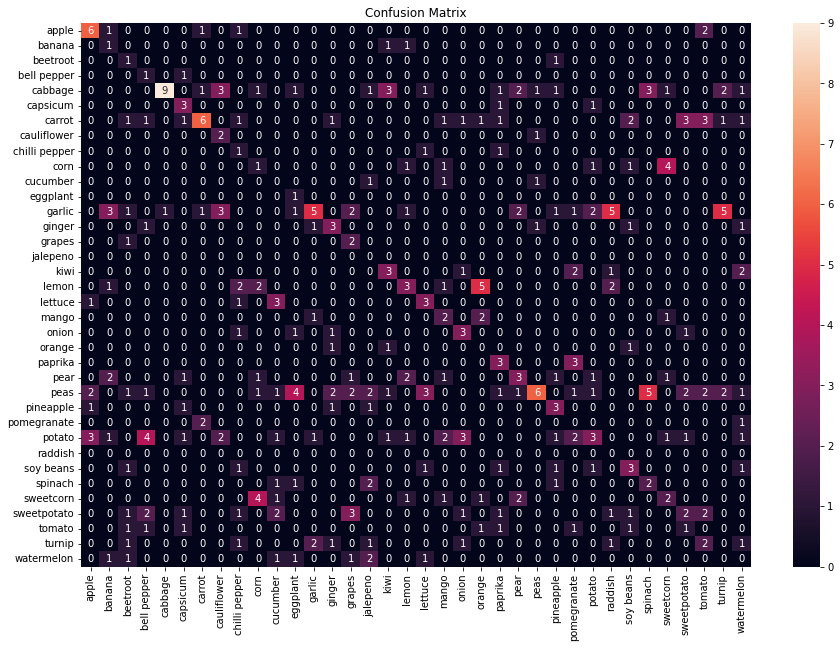

In [17]:
non_CNN_models('knn')

MODEL: rf
ACCURACY SCORE:
0.2907608695652174
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.38      0.45      0.42        11
           1       0.60      0.35      0.44        17
           2       0.50      0.38      0.43        13
           3       0.09      0.50      0.15         2
           4       0.60      0.46      0.52        13
           5       0.20      0.29      0.24         7
           6       0.55      0.40      0.46        15
           7       0.30      0.30      0.30        10
           8       0.00      0.00      0.00         5
           9       0.10      0.20      0.13         5
          10       0.20      0.14      0.17        14
          11       0.50      0.62      0.56         8
          12       0.60      0.32      0.41        19
          13       0.20      0.33      0.25         6
          14       0.18      0.20      0.19        10
          15       0.10      0.10      0.10        10
          16 

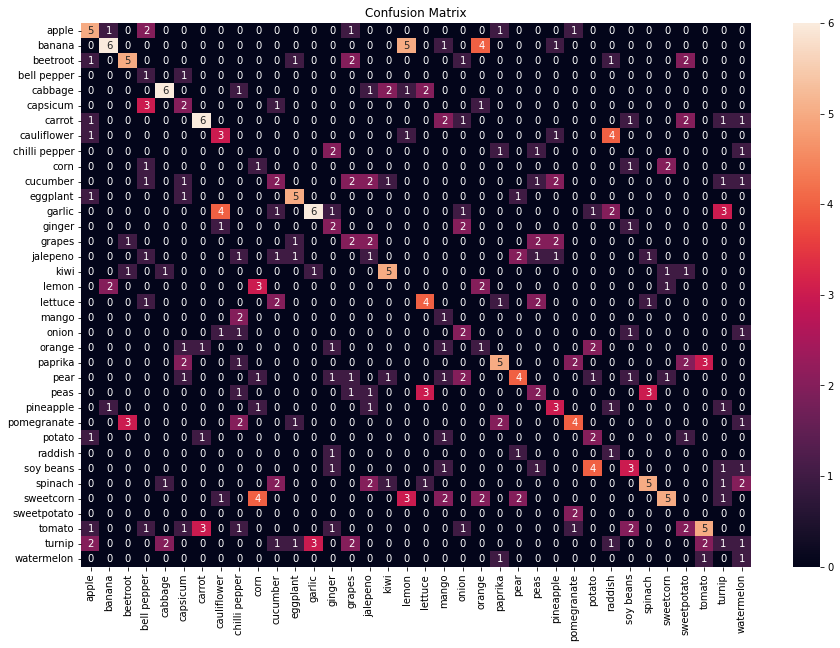

In [18]:
non_CNN_models('rf')

MODEL: dt
ACCURACY SCORE:
0.12771739130434784
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.38      0.26      0.31        19
           1       0.40      0.31      0.35        13
           2       0.20      0.22      0.21         9
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         8
           6       0.27      0.20      0.23        15
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.20      0.18      0.19        11
          12       0.30      0.30      0.30        10
          13       0.20      0.22      0.21         9
          14       0.18      0.12      0.14        17
          15       0.00      0.00      0.00         6
          16

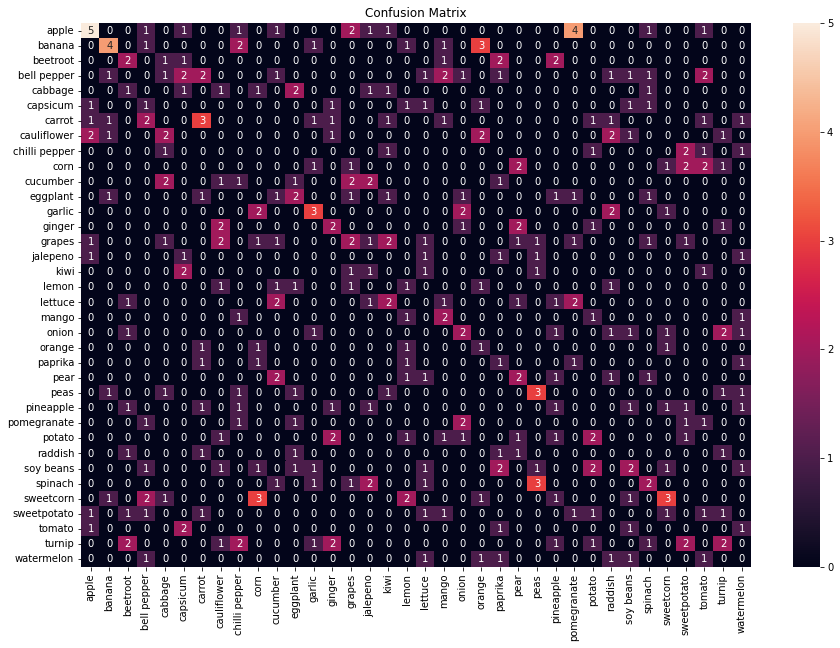

In [19]:
non_CNN_models('dt')

Functions that implement GridSearch so that we may find the best paramaters from given options that are then used in the previous non CNN models.

In [21]:
def KNN_with_grid():
    X, y, X_val, y_val, X_test, y_test = get_data()

    samples, nx, ny, nrgb = X_val.shape
    X_val = X_val.reshape((samples, nx*ny*nrgb))

    samples, nx, ny, nrgb = X_test.shape
    X_test = X_test.reshape((samples, nx*ny*nrgb))
    
    knn = KNeighborsClassifier()

    params = [{'n_neighbors': [3, 5, 9, 11],
         'weights': ['uniform', 'distance'],
         'leaf_size': [5, 6, 15, 18]}]
    gs_knn = GridSearchCV(knn,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
    gs_knn.fit(X_val, y_val)
    print(gs_knn.best_params_)
    # find best model score
    print(gs_knn.score(X_test, y_test))
    return gs_knn


def RF_with_grid():
    X, y, X_val, y_val, X_test, y_test = get_data()

    samples, nx, ny, nrgb = X_val.shape
    X_val = X_val.reshape((samples, nx*ny*nrgb))

    samples, nx, ny, nrgb = X_test.shape
    X_test = X_test.reshape((samples, nx*ny*nrgb))
    
    rf = RandomForestClassifier()

    params = [{'n_estimators': [100, 125],
         'min_samples_split': [2, 3, 5],
         'min_samples_leaf': [1, 3, 5]}]
    gs_rf = GridSearchCV(rf,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
    gs_rf.fit(X_val, y_val)
    print(gs_rf.best_params_)
    # find best model score
    print(gs_rf.score(X_test, y_test))
    return gs_rf

def DT_with_grid():
    X, y, X_val, y_val, X_test, y_test = get_data()

    samples, nx, ny, nrgb = X_val.shape
    X_val = X_val.reshape((samples, nx*ny*nrgb))

    samples, nx, ny, nrgb = X_test.shape
    X_test = X_test.reshape((samples, nx*ny*nrgb))
    
    dt = DecisionTreeClassifier()

    params = [{'max_depth': [None, 5],
         'min_samples_split': [2, 3, 5],
         'min_samples_leaf': [1, 2, 3]}]
    gs_dt = GridSearchCV(dt,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
    gs_dt.fit(X_val, y_val)
    print(gs_dt.best_params_)
    # find best model score
    print(gs_dt.score(X_test, y_test))
    return gs_dt

In [22]:
print('KNN:')
KNN_with_grid()

KNN:
{'leaf_size': 5, 'n_neighbors': 3, 'weights': 'distance'}
0.9510869565217391


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'leaf_size': [5, 6, 15, 18],
                          'n_neighbors': [3, 5, 9, 11],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [23]:
print('Random forest:')
RF_with_grid()

Random forest:
{'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 125}
0.9510869565217391


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'min_samples_leaf': [1, 3, 5],
                          'min_samples_split': [2, 3, 5],
                          'n_estimators': [100, 125]}],
             scoring='accuracy')

In [24]:
print('Decision tree:')
DT_with_grid()

Decision tree:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.8668478260869565


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [None, 5], 'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 3, 5]}],
             scoring='accuracy')

# CNN model

Convolutional Neuron Network model. It consists of multiple layers with repeating pattern of 2D convolutions and consequent max-pooling.

We flatten the data from 2D to 1D in order to dense it. Last dense layer is the output layer and the number of units is equal to the number of categories.

To reduce the impact of overfitting, we added dropout layers to our CNN model.

For the validation, we used given validation data instead of usually used validation split.

In [12]:
def model_CNN(X, y, X_val, y_val, epochs=6):
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2)))
    model.add(Dropout(0.6))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(36))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X, y, batch_size=128, validation_data=(X_val, y_val), epochs=epochs,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                    patience=2,
                                                                    restore_best_weights=True)])
    return model, history

Testing the CNN model on the given test data taken from the pickled files.

Predicted results are compared to the expected values and the incorrect predictions are displayed.

We tried to run the model with 50 epochs but the program stopped after 13 because of RAM shortage.

Epoch 1/50
31/31 [==============================] - 109s 3s/step - loss: 3.7859 - accuracy: 0.0347 - val_loss: 3.5370 - val_accuracy: 0.0456
Epoch 2/50
31/31 [==============================] - 107s 3s/step - loss: 3.4083 - accuracy: 0.0574 - val_loss: 3.3299 - val_accuracy: 0.0912
Epoch 3/50
31/31 [==============================] - 106s 3s/step - loss: 3.1690 - accuracy: 0.0944 - val_loss: 3.0691 - val_accuracy: 0.1140
Epoch 4/50
31/31 [==============================] - 106s 3s/step - loss: 2.8341 - accuracy: 0.1769 - val_loss: 2.7582 - val_accuracy: 0.1567
Epoch 5/50
31/31 [==============================] - 108s 3s/step - loss: 2.5224 - accuracy: 0.2501 - val_loss: 2.4892 - val_accuracy: 0.2764
Epoch 6/50
31/31 [==============================] - 107s 3s/step - loss: 2.2610 - accuracy: 0.3239 - val_loss: 2.3087 - val_accuracy: 0.3105
Epoch 7/50
31/31 [==============================] - 107s 3s/step - loss: 2.0507 - accuracy: 0.3818 - val_loss: 2.2116 - val_accuracy: 0.3504
Epoch 8/50
31

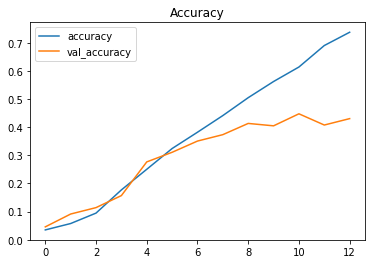

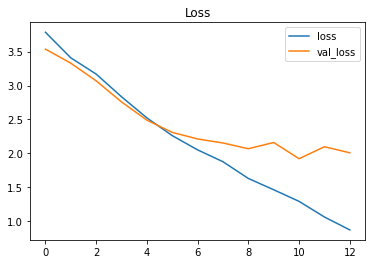

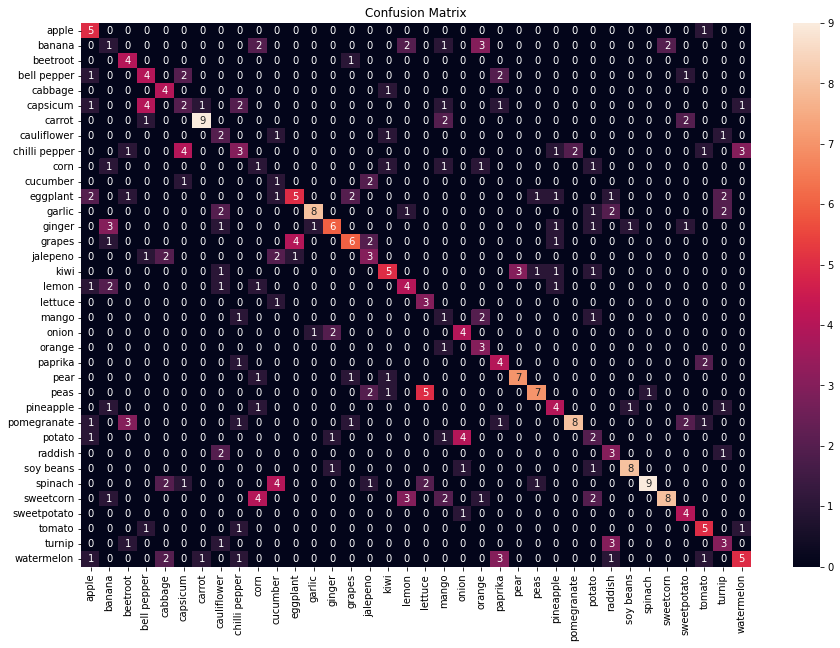

In [26]:
def predict_CNN_results(epochs):
    X, y, X_val, y_val, X_test, y_test = get_data()

    m, h = model_CNN(X, y, X_val, y_val, epochs)

    pred = m.predict(X_test)
    counter = 0
    print(pred.shape)
    best_pred = []
    for i in range(len(pred)):
      best_pred.append(np.argmax(pred[i]))
    print(y_test.shape)
    cm = confusion_matrix(best_pred, y_test)
    for i in range(len(pred)):
        j = np.argmax(pred[i])
        if (abs(y_test[i] - j) > 1):
            print("Predicted: {:13s} ({:2d}) | actually: {:13s} ({:2d})".format(rev_cat[j], j, rev_cat[y_test[i]], y_test[i]))
            counter += 1
    print("missed {:3d} out of {:3d}".format(counter, len(pred)))
    print("Accuracy on testing data: {:3.3f} %".format((1-counter/len(pred))*100))
    process_history(h, cm, y_test)




predict_CNN_results(50)

# SVM model - OBSOLETE AND ABANDONED

Model based on the support vector machine. We have included grid search (looking back, don't do this kids). This model takes approximately 8 hours to run on our 16GB ram machine with 8 cores CPU.

This model was abandoned after our initial tests with it, but we decided to keep it here for old time's sake and as a warning for those that shall oppose the one true ruling model, CNN.

BEWARE: run at your own risk. 

In [ ]:
def model_lin_svm(X, y, X_val, y_val):
    X_new = []
    X_val_new = []

    print("Data loaded")
    for i in range(len(X)):
        X_new.append(X[i].flatten())
    for i in range(len(X_val)):
        X_val_new.append(X_val[i].flatten())

    X_new = np.array(X_new)
    X = X_new
    X_val_new = np.array(X_val_new)
    X_val = X_val_new
    print(X_val.shape, y_val.shape)


    param_grid = {'kernel': ['rbf', 'poly']}
    print("param_grid created")
    svc = svm.SVC(probability=True)
    model = GridSearchCV(svc, param_grid)
    print("model created")
    model.fit(X, y)
    return model

Testing the SVM model on the test data. It is required to reshape the images from 4D (numberOfImages, height, width, color) to 2D (numberOfImages, flattenedImage).

Predicted results are compared to the expected values and the incorrect predictions are displayed.

In [ ]:
def predict_SVM_results():
    X, y, X_val, y_val, X_test, y_test = get_data()

    X_test_new = []
    for i in range(len(X_test)):
        X_test_new.append(X_test[i].flatten())
    X_test_new = np.array(X_test_new)
    X_test = X_test_new

    m = model_lin_svm(X, y, X_val, y_val)

    pred = m.predict(X_test)
    counter = 0
    for i in range(len(pred)):
        j = pred[i]
        if y_test[i] != j:
            print("Predicted: {:13s} ({:2d}) | actually: {:13s} ({:2d})".format(rev_cat[j], j, rev_cat[y_test[i]], y_test[i]))
            counter += 1
    print("missed {:3d} out of {:3d}".format(counter, len(pred)))
    print("Accuracy on testing data: {:3.3f}%".format((1-counter/len(pred))*100))

#predict_SVM_results()